In [5]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
import os
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 200

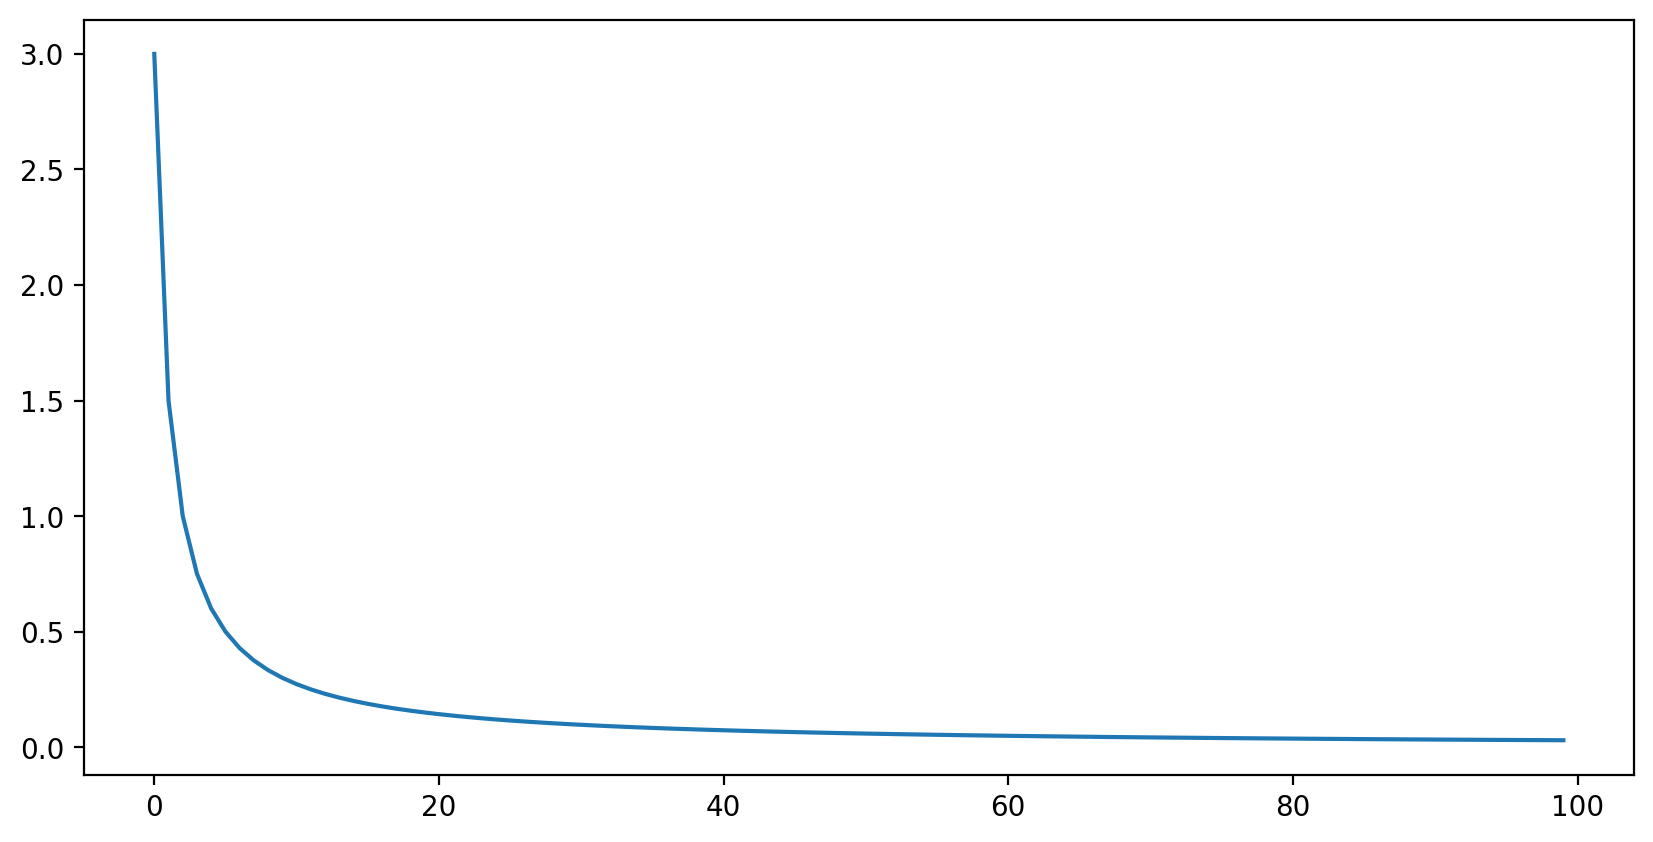

In [6]:
val = np.arange(100).astype(np.float64)
val[:] = val[:] + 1
val[:] = 0.25*12/val[:]

plt.plot( val )
plt.show()

In [3]:
def ncc(patch1, patch2, w):
    xa = np.mean(patch1)
    ya = np.mean(patch2)

    a = np.sum( (patch1 - xa) * (patch2 - ya) ).astype(np.float64)
    b = np.sqrt( np.sum( np.square(patch1-xa) ) / w ).astype(np.float64)
    c = np.sqrt( np.sum( np.square(patch2-ya) ) / w ).astype(np.float64)
    if a == 0 or b == 0 or c == 0:
        return 0
    return ( a / ( b * c ) ) / w

def disparity(image1, image2, w):
    
    disparities = np.zeros((len(image1),len(image1[0])))
    for x in range( w, len(image1) - w ):
        for y in range( w, len(image1[0]) - w ):
            
            n = (w+w+1) * (w+w+1)
            patch1 = image1[x-w:x+w+1,y-w:y+w+1,0].reshape(-1)
            # print(patch1)
            patch2 = image2[x-w:x+w+1, max(0,y-10): min(len(image1[0]),y+10+1),0]
            maks_ncc = -np.Infinity
            maks_disp = 0 
            # for yy in range( max(w,y-10), min(y+10+1,len(image1[0])-w) ):
            #     patch3 = image2[x-w:x+w+1,yy-w:yy+w+1,0].reshape(-1)
            #     nccc = ncc(patch1, patch3, n )
            #     if nccc > maks_ncc:
            #         maks_ncc = nccc
            #         maks_disp = yy - y
            for yy in range( 0, len(patch2[0])-w-w ):   
                patch3 = patch2[:,yy:yy+w+w+1]
                nccc = ncc(patch1, patch3.reshape(-1), n )
                if nccc > maks_ncc:
                    maks_ncc = nccc
                    maks_disp = yy - 10
            if maks_ncc <= 0:
                disparities[x,y] = 0
            else:
                disparities[x,y] = maks_disp
    return disparities

i = cv2.imread("./data/disparity/office2_left.png")
ii = cv2.imread("./data/disparity/office2_right.png")

d1 = -disparity(i,ii,2)
d2 = disparity(ii,i,2)


KeyboardInterrupt: 

In [ ]:

med = np.zeros( d1.shape )
size = 5
# for x in range( size , len(d1) - size ):
#     for y in range( size, len(d1[0]) - size ):
#         med[x,y] = np.median( d1[x-size:x+size+1,y-size:y+size+1] )

plt.subplot(2,1,1)
plt.imshow(d1, cmap="jet")

plt.subplot(2,1,2)
plt.imshow(d2, cmap="jet")
plt.show()

d = np.copy(d1)
d[d <= 0] = 0
dd = np.zeros(d.shape)
for x in range( size , len(d1) - size ):
    for y in range( size, len(d1[0]) - size ):
        dd[x,y] = np.median( d[x-size:x+size+1,y-size:y+size+1] )
plt.subplot(2,1,1)
plt.imshow(dd, cmap="jet")


d = np.copy(d2)
d[d <= 0] = 0
dd = np.zeros(d.shape)
for x in range( size , len(d1) - size ):
    for y in range( size, len(d1[0]) - size ):
        dd[x,y] = np.median( d[x-size:x+size+1,y-size:y+size+1] )

plt.subplot(2,1,2)
plt.imshow(dd, cmap="jet")
plt.show()



In [7]:
f = np.array([[0,0,0.002],[0,0,-0.012],[-0.001,0.011,-0.085]])
x1 = np.array([300,120,1]).reshape((3,1))
x2 = np.array([300,170,1]).reshape((3,1))
print(f @ x1)
print(f @ x2)

#no intersection?
#the epipol?

[[ 0.002]
 [-0.012]
 [ 0.935]]
[[ 0.002]
 [-0.012]
 [ 1.485]]


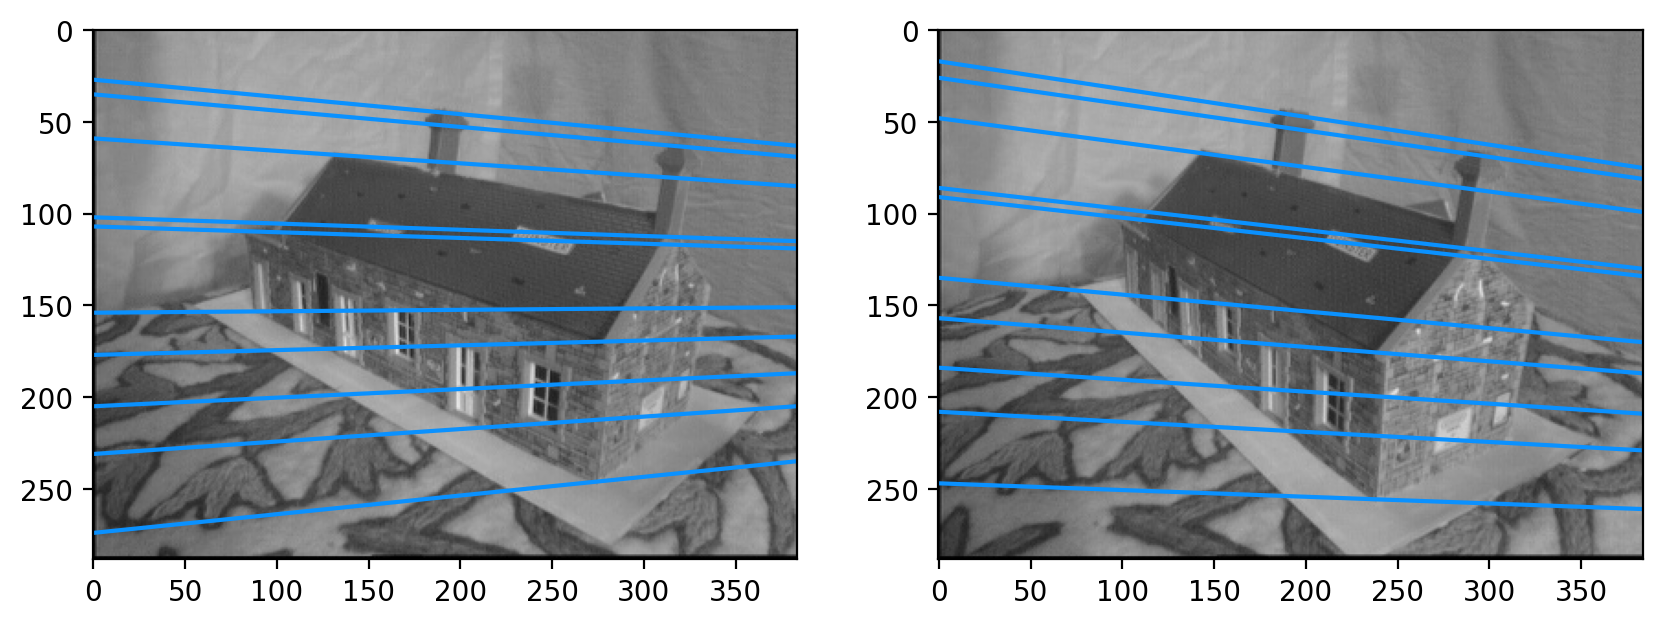

In [8]:
from a5_utils import normalize_points,draw_epiline

def read_data(filename):
	with open(filename) as f:
		s = f.read()

	return np.fromstring(s, sep=' ')

def fundamental_matrix(points):
    x1,t1 = normalize_points(points[:,0:2])
    x2,t2 = normalize_points(points[:,2:])

    a = np.zeros( (len(x1),9) )
    for i, (x,y) in enumerate(zip(x1,x2)):
        a[i,:] = [ x[0]*y[0], x[0]*y[1], x[0], x[1]*y[0], x[1]*y[1], x[1], y[0], y[1], 1 ]
    u,d,v = np.linalg.svd(a)
    print(u,d,v)
    v = v.T
    vv = v[:,8].reshape((3,3))
    u,d,v = np.linalg.svd(vv)
    d = np.diag(d)
    d[2,2] = 0
    f = u @ d @ v
    # f = vv
    f = t2.T @ f.T @ t1
    return f

p = read_data("./data/epipolar/house_points.txt")
p = p.reshape((int(len(p)/4),4))
f = fundamental_matrix(p)


i = cv2.imread("data/epipolar/house1.jpg")
plt.subplot(1,2,1)
plt.imshow(i)

for ind in range(len(p)):
    point = np.ones(3)
    point[:2] = p[ind,2:]
    draw_epiline( f.T   @ point, len(i), len(i[0]) )

i2 = cv2.imread("data/epipolar/house2.jpg")
plt.subplot(1,2,2)
plt.imshow(i2)

for ind in range(len(p)):
    point = np.ones(3)
    point[:2] = p[ind,:2]
    draw_epiline( f @ point, len(i2), len(i2[0]) ) 

plt.show()

In [ ]:
def reprojection_error_avg(f, p1, p2):
    l1 = f.T @ p2
    l2 = f @ p1
    
    d1 = abs( (l1[0]*p1[0] + l1[1]*p1[1] + l1[2]))/np.sqrt( l1[0]**2 + l1[1]**2 )
    d2 = abs( (l2[0]*p2[0] + l2[1]*p2[1] + l2[2]))/np.sqrt( l2[0]**2 + l2[1]**2 )
   
    return (d1+d2)/2

x1 = np.array([85,233,1])
x2 = np.array([67,219,1])
print(reprojection_error_avg(f,x1,x2))

def errors(p,f):
    dist = 0
    for i in range(len(p)):
        point1 = np.ones(3)
        point1[:2] = p[i,:2]

        point2 = np.ones(3)
        point2[:2] = p[i,2:]

        dist += reprojection_error_avg(f,point1,point2)
    return dist/len(p)

print( errors(p,f) )

In [ ]:
def reprojection_error(f, p1, p2):
    l1 = f.T @ p2
    l2 = f @ p1
    
    d1 = abs( (l1[0]*p1[0] + l1[1]*p1[1] + l1[2]))/np.sqrt( l1[0]**2 + l1[1]**2 )
    d2 = abs( (l2[0]*p2[0] + l2[1]*p2[1] + l2[2]))/np.sqrt( l2[0]**2 + l2[1]**2 )
    # print(d1,d2)
    return d1,d2

def get_inliers(f,p,t):
    which = list()

    for i in range(len(p)):
        point1 = np.ones(3)
        point1[:2] = p[i,:2]

        point2 = np.ones(3)
        point2[:2] = p[i,2:]
        
        err1,err2 = reprojection_error(f,point1,point2) 
        if err1 < t and err2 < t:
            which.append(i)
    
    return which

def ransac_fundamental(matches, k, t):
    which = list()
    best_len = 0
    best_matches = list()
    best_err = np.inf

    for i in range(k):
        rand_i = np.random.choice(len(matches), size=8, replace=False)
        rand = matches[rand_i]
        f = fundamental_matrix(rand)
        inliers = get_inliers(f,rand,t)
        if len(inliers) > best_len:
            best_matches = rand
            best_len = len(inliers)
        elif len(inliers) == best_len:
            napaka = errors( rand, fundamental_matrix(rand) )
            if napaka < best_err:
                best_err = napaka
                best_matches = rand
                best_len = len(inliers)

        which.extend(rand_i[inliers])

    which = np.unique(which)
    return best_matches,matches[which]

def draw_points(x,y,hex):
    plt.plot( x, y, 'o' ,markerfacecolor='none', color=hex )

        
m = read_data("./data/epipolar/house_matches.txt")
m = m.reshape((int(len(m)/4),4))

best,inl = ransac_fundamental(m, 100, 0.01)
f1 = fundamental_matrix(best)
f2 = fundamental_matrix(inl)
rand_point = best[np.random.choice(len(best), size=1, replace=False)][0]


point = np.ones(3)
point[:2] = rand_point[2:]

i = cv2.imread("data/epipolar/house1.jpg")
plt.subplot(1,2,1)
plt.imshow(i)
draw_points(m[:,0],m[:,1],"#b3000c") #all
draw_points(inl[:,0],inl[:,1],"#44e354") #inl
draw_points(rand_point[0],rand_point[1],"#342dfc") #choosen
draw_epiline( f1.T @ point, len(i), len(i[0]) )


point = np.ones(3)
point[:2] = rand_point[:2]

i2 = cv2.imread("data/epipolar/house2.jpg")
plt.subplot(1,2,2)
plt.imshow(i2)
draw_points(m[:,2],m[:,3],"#b3000c")
draw_points(inl[:,2],inl[:,3],"#44e354")
draw_points(rand_point[2],rand_point[3],"#342dfc") #choosen
draw_epiline( f1 @ point, len(i), len(i[0]) )

plt.show()

In [ ]:
def gaussdx(sigma, size):
    if size > 2 * 3 * sigma + 1:
        size = 2 * 3 * sigma + 1
    gaus = np.arange(-size,size+1)
    gaus = gaus.astype(float)
    gaus[:] = np.multiply( -1/(np.sqrt(2 * np.pi) * np.power(sigma,3)), np.multiply(gaus[:],np.exp(np.divide(-np.square(gaus[:]),2*np.square(sigma)))) )
    return gaus / sum(abs(gaus))

def gauss(sigma, size):
    if size > 3 * sigma + 1:
        size = 3 * sigma + 1
    gaus = np.arange(-size,size+1)
    gaus = gaus.astype(float)
    gaus[:] = np.multiply(1/(np.sqrt(2 * np.pi) * sigma), np.exp(np.divide(-np.square(gaus[:]),2*np.square(sigma))) )
    return gaus / sum(gaus)

def partial_derivatives(image, sigma, size):
    image = image.astype(float)
    g = gauss(size,sigma)
    d = gaussdx(size,sigma)
    ix = cv2.filter2D(cv2.filter2D(image,-1, g ,borderType=4),-1,cv2.transpose(np.flip(d)),borderType=4) 
    iy = cv2.filter2D(cv2.filter2D(image,-1, np.flip(d) ,borderType=4),-1,cv2.transpose(g),borderType=4)
    ixx = cv2.filter2D(cv2.filter2D(ix,-1, g ,borderType=4),-1,cv2.transpose(np.flip(d)),borderType=4) 
    ixy = cv2.filter2D(cv2.filter2D(ix,-1, np.flip(d) ,borderType=4),-1,cv2.transpose(g),borderType=4) 
    iyy = cv2.filter2D(cv2.filter2D(iy,-1, np.flip(d) ,borderType=4),-1,cv2.transpose(g),borderType=4) 
    return [ix,iy,ixx,ixy,iyy]

def hessian_points(image,sigma,size,thresh):
    _,_,xx,xy,yy = partial_derivatives(image, sigma, size)
    det = np.copy(xx)
    det[:] = np.power(sigma,4) * (xx[:] * yy[:] - np.square(xy[:]))
    thresholded = np.copy(det)
    thresholded = maxima_threshold(thresholded,thresh)
    print(np.amax(det))
    
    return [det,thresholded]

def harris_points(image, sigma, threshold):
    x,y,_,_,_ = partial_derivatives(image, sigma, 3*sigma)
    k = gauss(1.6 * sigma, 3 * 1.6 * sigma)

    xx = cv2.filter2D(cv2.filter2D(np.multiply(x,x),-1,cv2.transpose(k)),-1,k)
    yy = cv2.filter2D(cv2.filter2D(np.multiply(y,y),-1,cv2.transpose(k)),-1,k)
    xy = cv2.filter2D(cv2.filter2D(np.multiply(x,y),-1,cv2.transpose(k)),-1,k)

    det = np.subtract(np.multiply(xx,yy), np.square(xy))
    trace = np.add(xx,yy).astype(np.float64)

    c = np.copy(det).astype(np.float64)
    c = np.subtract( det, 0.06*np.square(trace) )
    thresh = maxima_threshold(np.copy(c),threshold)
    print(np.amax(c))
    
    return [c, thresh]

def maxima_threshold(c, thresh):
    det = np.pad(c, [(1,1), (1,1)], "constant", constant_values=0)
    det[ det < thresh ] = 0
    new = np.copy(det)
    indexes = np.nonzero(det)

    for i in range( len(indexes[0]) ):
        x = indexes[0][i]
        y = indexes[1][i]
        if det[x,y] < np.amax( det[x-1:x+2,y-1:y+2] ):
            new[x,y] = 0
        
    det = new
    det = det[1:len(det)-1,1:len(det[0])-1]
    return det


def simple_descriptors(I, pts, bins=16, rad=40, w=11):
	g = gauss(w, 3*w)
	d = gaussdx(w, 3*w)

	# Ix = cv2.filter2D(I, cv2.CV_32F, g.T)
	# Ix = cv2.filter2D(Ix, cv2.CV_32F, d)

	# Iy = cv2.filter2D(I, cv2.CV_32F, g)
	# Iy = cv2.filter2D(Iy, cv2.CV_32F, d.T)

	# Ixx = cv2.filter2D(Ix, cv2.CV_32F, g.T)
	# Ixx = cv2.filter2D(Ixx, cv2.CV_32F, d)

	# Iyy = cv2.filter2D(Iy, cv2.CV_32F, g)
	# Iyy = cv2.filter2D(Iyy, cv2.CV_32F, d.T)
    
	Ix = cv2.filter2D(cv2.filter2D(I,cv2.CV_32F, g ,borderType=4),cv2.CV_32F,cv2.transpose(np.flip(d)),borderType=4) 
	Iy = cv2.filter2D(cv2.filter2D(I,cv2.CV_32F, np.flip(d) ,borderType=4),cv2.CV_32F,cv2.transpose(g),borderType=4)
	Ixx = cv2.filter2D(cv2.filter2D(Ix,cv2.CV_32F, g ,borderType=4),cv2.CV_32F,cv2.transpose(np.flip(d)),borderType=4) 
	Ixy = cv2.filter2D(cv2.filter2D(Ix,cv2.CV_32F, np.flip(d) ,borderType=4),cv2.CV_32F,cv2.transpose(g),borderType=4) 
	Iyy = cv2.filter2D(cv2.filter2D(Iy,cv2.CV_32F, np.flip(d) ,borderType=4),cv2.CV_32F,cv2.transpose(g),borderType=4) 

	mag = np.sqrt(Ix**2+Iy**2)
	mag = np.floor(mag*((bins-1)/np.max(mag)))

	feat = Ixx+Iyy
	feat += abs(np.min(feat))
	feat = np.floor(feat*((bins-1)/np.max(feat)))

	desc = []

	for x,y in pts:
		minx = max(x-rad, 0)
		maxx = min(x+rad, I.shape[0])
		miny = max(y-rad, 0)
		maxy = min(y+rad, I.shape[1])
		r1 = mag[minx:maxx, miny:maxy].reshape(-1)
		r2 = feat[minx:maxx, miny:maxy].reshape(-1)
		
		a = np.zeros((bins, bins))
		for m, l in zip(r1, r2):
			a[int(m), int(l)] += 1

		a = a.reshape(-1)
		a/=np.sum(a)

		desc.append(a)

	return np.array(desc)

def find_correspondences(desc1, desc2):
	hellingers = np.zeros((len(desc1), len(desc2)))
	for i,x in enumerate(desc1):
		for j,y in enumerate(desc2):
			hellingers[i,j] = np.sqrt(np.multiply(0.5, np.sum(np.square(np.subtract(np.sqrt(x), np.sqrt(y))))))


	best_indexes = np.zeros(len(desc1))

	# for each point in desc1, get distances to points in desc2
	for i,x in enumerate(hellingers):
		best_indexes[i] = np.nonzero( (x == np.amin(x)) )[0][0]
	return best_indexes

def display_matches(im1, im2, pts1, pts2, matches):
	first = 1
	second = 2
	if len(im1) != len(im2):
		length = max(len(im1),len(im2))
		first = np.zeros((length,len(im1[0])))
		second = np.zeros((length,len(im2[0])))
		first[:len(im1),:len(im1[0])] = im1
		second[:len(im2),:len(im2[0])] = im2
	else:
		first = im1
		second = im2

	I = np.hstack((first,second))
	w = first.shape[1]
	plt.clf()
	plt.imshow(I, cmap="gray")

	for i, j in matches:
		p1 = pts1[int(i)]
		p2 = pts2[int(j)]
		plt.plot(p1[1], p1[0], 'o',markerfacecolor='none',color="#00FF55")
		plt.plot(p2[1]+w, p2[0], 'o',markerfacecolor='none',color="#00FF55")
		plt.plot([p1[1], p2[1]+w], [p1[0], p2[0]], color="#00FF55")

	plt.draw()

def find_matches(image1, image2):
    _,t1 = harris_points(image1,3,100)
    # _,t1 = hessian_points(image1,3,9,1000)

    points1 = np.nonzero(t1)
    points1 = np.vstack((points1[0],points1[1])).T
    d1 = simple_descriptors(image1, points1,32,40,3)


    _,t2 = harris_points(image2,3,100)
    # _,t2 = hessian_points(image2,3,9,1000)

    points2 = np.nonzero(t2)
    points2 = np.vstack((points2[0],points2[1])).T
    d2 = simple_descriptors(image2, points2,32,40,3)

    korespondence1 = find_correspondences(d1,d2)
    korespondence2 = find_correspondences(d2,d1)

    for i,k in enumerate(korespondence1):
        if not korespondence2[int(k)] == i:
            korespondence1[i] = -1

    matches = np.nonzero( (korespondence1 > -1) )[0]
    fromother = np.take(korespondence1, matches) 
    res = (np.vstack((matches,fromother)).T).astype(int)
    return [points1, points2, res]

def draw_pointss(arr):
    plt.plot( np.nonzero(arr)[1], np.nonzero(arr)[0], 'x',markerfacecolor='none',color="#00FF55")

def draw_points(x,y,hex):
    plt.plot( x, y, 'o' ,markerfacecolor='none', color=hex )




i = cv2.imread("./data/epipolar/house1.jpg")
i = i[:,:,0]

i2 = cv2.imread("data/epipolar/house2.jpg")
i2 = i2[:,:,0]

def automatic_estimation(i1,i2):

    p1,p2,mtch = find_matches(i,i2)
    cors = np.zeros((len(mtch),4))

    for match in range(len(mtch)):
        cors[match,:2] = np.flip(p1[ mtch[match,0] ])
        cors[match,2:] = np.flip(p2[ mtch[match,1] ])

    # display_matches(i,i2,p1,p2,mtch)
    # plt.show()

    best,inl = ransac_fundamental(cors, 100, 0.001)
    f1 = fundamental_matrix(best)
    f2 = fundamental_matrix(inl)
    return best,inl,f1,cors

best,inl,f1,cors = automatic_estimation(i,i2)
rand_point = best[np.random.choice(len(best), size=1, replace=False)][0]

point = np.ones(3)
point[:2] = rand_point[2:]

plt.subplot(1,2,1)
plt.imshow(i,cmap="gray")
draw_points(cors[:,0],cors[:,1],"#b3000c") #all
draw_points(inl[:,0],inl[:,1],"#44e354") #inl
draw_points(rand_point[0],rand_point[1],"#342dfc") #choosen
draw_epiline( f1.T @ point, len(i), len(i[0]) )


point = np.ones(3)
point[:2] = rand_point[:2]

plt.subplot(1,2,2)
plt.imshow(i2,cmap="gray")
draw_points(cors[:,2],cors[:,3],"#b3000c")
draw_points(inl[:,2],inl[:,3],"#44e354")
draw_points(rand_point[2],rand_point[3],"#342dfc") #choosen
draw_epiline( f1 @ point, len(i), len(i[0]) )
plt.title("inliers: {}%, error: {}".format(100*len(inl)/len(cors), errors(best,f1) )) 

plt.show()


In [ ]:
def triangulate(cors,c1,c2):
    res = np.zeros((len(cors),3))
    for i,points in enumerate(cors):
        p1 = np.ones(3)
        p1[:2] = points[:2]
        p2 = np.ones(3)
        p2[:2] = points[2:]

        a1 = [[0,-1,p1[1]],[1,0,-p1[0]],[-p1[1],p1[0],0]] @ c1
        a2 = [[0,-1,p2[1]],[1,0,-p2[0]],[-p2[1],p2[0],0]] @ c2
        a = np.zeros((4,4))
        a[:2,:] = a1[:2,:]
        a[2:,:] = a2[:2,:]
        
        _,_,v = np.linalg.svd(a)
        v = v.T
        v = v[:,3]
        v = v / v[3]
        v = v[:3]
        res[i] = v
    return res


c1 = read_data("./data/epipolar/house1_camera.txt")
c1 = c1.reshape((int(len(c1)/4),4))

c2 = read_data("./data/epipolar/house2_camera.txt")
c2 = c2.reshape((int(len(c2)/4),4))

p = read_data("./data/epipolar/house_points.txt")
p = p.reshape((int(len(p)/4),4))



fig = plt.figure()

i1 = cv2.imread("./data/epipolar/house1.jpg")
i1 = i1[:,:,0]

i2 = cv2.imread("data/epipolar/house2.jpg")
i2 = i2[:,:,0]

fig.add_subplot(1,3,1)
plt.imshow(i1, cmap="gray")
for i, pt in enumerate(p):
    plt.plot([pt[0]],[pt[1]],'r.') 
    plt.text(pt[0],pt[1], str(i)) 

fig.add_subplot(1,3,2)
plt.imshow(i2, cmap="gray")
for i, pt in enumerate(p):
    plt.plot([pt[2]],[pt[3]],'r.') 
    plt.text(pt[2],pt[3], str(i)) 



ax = fig.add_subplot(133, projection='3d') # define 3D subplot
pnts = triangulate(p,c1,c2)
T = np.array([[-1,0,0],[0,0,1],[0,-1,0]]) # transformation matrix
res = np.dot(pnts,T)
for i, pt in enumerate(res):
    plt.plot([pt[0]],[pt[1]],[pt[2]],'r.') # plot points
    ax.text(pt[0],pt[1],pt[2], str(i)) # plot indices
plt.show()
